# CTM MILP Model Running Environment

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *
from ctmmodels.delaythroughput import DelayThroughputSimplex as Model

In [3]:
IMAGE_PATH = 'graphs/'
DF_PATH = 'dataframes/'

**Notes on the models and parameters being used:**

* 2 separate formulations were made: 1 dealing with individual movements in the intersection, and another dealing with phases in the stoplight. The latter has 33% less binary variables, and thus performed better in basic tests.

* Saturation flow rate will be set to 600 vph instead of the 450 vph in the parent paper; this is so as to test both under and over saturated conditions.

* Traffic will be distributed evenly between the 3 possible turns (left, through, and right). This is based on previous tests where left was getting essentially 0 green time.

* Time range will be set to 60 seconds, or 30 time steps at 2 seconds per time step. Preliminary experiments show that 50 is the optimal cycle time for both delay and throughput (at demands ranging from 450 to 900 vph). *However*, previous tests on this model showed that no time was allotted to left turns when the cycle time was too small.

In [3]:
time_range = 30
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 1.0/3.0,
    'r_through': 1.0/3.0,
    'r_right': 1.0/3.0,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20
}

# Varying parameters: demand, use_flow_weight, flow_weight, alpha

In [4]:
def run_model(demand, alpha=1, beta=0, gamma=0, log_output=True):
    model = Model(
        demand=demand,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        **parameters
    )
    model.generate()
    runtime = model.solve(log_output=log_output)
    dfx, dfy, dfg = model.return_solution()
    dfparams = model.return_parameters()
    obj_values = model.return_objective_value()
    return dfx, dfy, dfg, dfparams, obj_values, runtime

In [5]:
dfx, dfy, dfg, dfparams, obj_values, runtime = run_model((450,900))

Solving...
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 1942 rows and 292 columns.
MIP Presolve modified 752 coefficients.
Aggregator did 130 substitutions.
Reduced MIP has 3478 rows, 1858 columns, and 12224 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.04 sec. (12.68 ticks)
Found incumbent of value 2565.830830 after 0.09 sec. (26.16 ticks)
Probing fixed 0 vars, tightened 139 bounds.
Probing time = 0.00 sec. (0.61 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 604 rows and 104 columns.
Aggregator did 88 substitutions.
Reduced MIP has 2786 rows, 1666 columns, and 10516 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (5.61 ticks)
Probing time = 0.00 sec. (0.41 ticks)
Tried aggregator 1 time.
Reduced MIP has 2786 rows, 1666 columns, and 10516 nonzeros.
Reduced MIP has 240 binaries, 0 generals, 0 SOSs, and 0 indicators.


## Intersection Cell Network

![title](img/4leg-intersection.png)

## Setting the path of cells to check

In [19]:
_approach = 0

_approach_labels = [
    'Southbound',
    'Westbound',
    'Northbound',
    'Eastbound'
]
_approach_terms = [
    'Left',
    'Through',
    'Right'
]

_cell_path = [
    (CELL_SOURCE,0,_approach),
    (CELL_NORMAL,0,_approach),
    (CELL_NORMAL,1,_approach),
    (CELL_NORMAL,2,_approach),
    (CELL_MOVEMENT,THROUGH_TURN,_approach),
    S_mapping((CELL_MOVEMENT,THROUGH_TURN,_approach))[0]
]

def movement_paths(approach):
    return [
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,LEFT_TURN,approach),
            S_mapping((CELL_MOVEMENT,LEFT_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,THROUGH_TURN,approach),
            S_mapping((CELL_MOVEMENT,THROUGH_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,RIGHT_TURN,approach),
            S_mapping((CELL_MOVEMENT,RIGHT_TURN,approach))[0]
        ]
    ]

## Comparing cell volumes

In [7]:
def plot_volume(dfx, cell_path, title, headless=True, filename='volume.png'):
    dfx_approach = pd.concat([
        dfx[dfx.cell == c].sort_values(by='timestep')
        for c in cell_path
    ]).pivot(index='timestep', columns='cell', values='volume')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))
    
    sns.lineplot(data=dfx_approach, ax=axs[0])
    sns.lineplot(data=dfx_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Volume of cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous volume')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Volume of cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative volume')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing flows

In [8]:
def plot_flow(dfy, cell_path, title, headless=True, filename='flow.png'):
    dfy_approach = pd.concat([
        dfy[dfy.cell_from == c].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
        for c in cell_path
    ]).reset_index().pivot(index='timestep', columns='cell_from', values='flow')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))

    sns.lineplot(data=dfy_approach, ax=axs[0])
    sns.lineplot(data=dfy_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Flow from cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous flow')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Flow from cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative flow')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing specific green time

In [9]:
all_phases = [intToBinTuple(x) for x in range(8)]
all_phases_labels = [
    "Left, Westbound",
    "Through, Eastbound",
    "Left, Southbound",
    "Through, Southbound",
    "Left, Eastbound",
    "Through, Westbound",
    "Left, Northbound",
    "Through, Northbound",
]

def plot_greentime(dfg, title, headless=True, filename='greentime.png'):
    dfg_map = dfg.pivot(index='timestep', columns='cell', values='is_green')

    fig, axs = plt.subplots(8,1,figsize=(18,18), sharey=True)

    for ndx, t in enumerate(all_phases):
        sns.lineplot(data=dfg_map[t], ax=axs[ndx])
        axs[ndx].text(0.01,.5,all_phases_labels[ndx],
            horizontalalignment='left',
            transform=axs[ndx].transAxes,
            fontsize='large')
        axs[ndx].set_xticks(time_ticks, minor=False)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Generating graphs for each model case

In [20]:
def generate_graphs(dfx, dfy, dfg, capacity, max_flow, demand, alpha, flow_weight, approach, folder=''):
    cell_paths = movement_paths(approach)
    
    for ndx, cellpath in enumerate(cell_paths):
        if dfx is not None:
            plot_volume(dfx,
                        cellpath,
                        '''Volume in cells at {} vph and {}% delay weight ({} turn)
                        (Cap: {:.2f}, {})'''
                            .format(demand, alpha*100, _approach_terms[ndx], capacity, _approach_labels[approach]),
                        filename=folder+'volumes/{}vph_{}alpha_{}_{}.png'
                            .format(demand, alpha, _approach_labels[approach], _approach_terms[ndx].lower()))
        
        if dfy is not None:
            plot_flow(dfy,
                      cellpath,
                      '''Flow from cells at {} vph and {}% delay weight ({} turn)
                      (Cap: {:.2f}, {})'''
                          .format(demand, alpha*100, _approach_terms[ndx], capacity, _approach_labels[approach]),
                      filename=folder+'flows/{}vph_{}alpha_{}_flow_{}.png'
                          .format(demand, alpha, _approach_labels[approach], _approach_terms[ndx].lower()))
    
    if dfg is not None:
        plot_greentime(dfg,
                       '''Green times at {} vph and {}% delay weight
                       (Cap: {:.2f}, {})'''
                           .format(demand, alpha*100, capacity, _approach_labels[approach]),
                       filename=folder+'greentimes/{}vph_{}alpha_{}_greetime.png'
                           .format(demand, alpha, _approach_labels[approach]))

In [11]:
def plot_obj_values(obj_values, title, xaxis, xlabel, headless=True, filename='obj.png'):
    fig, axs = plt.subplots(1,2,figsize=(20,10))

    axs[0].plot(xaxis, [x[0] for x in obj_values])
    axs[0].set_title("Computed total delay")
    axs[0].set_ylabel("Total vehicle delay (timesteps)")
    axs[0].set_xlabel(xlabel)

    axs[1].plot(xaxis, [x[1] for x in obj_values])
    axs[1].set_title("Computed total throughput")
    axs[1].set_ylabel("Total vehicle throughput (veh)")
    axs[1].set_xlabel(xlabel)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Saving dataframes

In [12]:
def save_df(df, filename):
    df.to_pickle(DF_PATH + filename + ".pkl")

## 0. Testing if asymmetric demand works

In [22]:
for i in range(4):
    generate_graphs(dfx, dfy, dfg, dfparams.capacity[(3,0,1)], dfparams.max_flow[(3,0,1)], (450,900), 1, 0, i, folder='asymmetric/')

## 1. Plotting delay and throughput on the simplex (given an asymmetric demand)

In [23]:
def generate_simplex(steps=10):
    simplex = [(a,b,steps-(a+b)) for a in range(steps+1) for b in range(steps - a + 1)]
    normalized = []
    for point in simplex:
        normalized.append((float(point[0]) / steps, float(point[1]) / steps, float(point[2]) / steps))
    return normalized

In [24]:
def run_on_simplex(demand=900, simplex_slice=[], log_output=False, folder='triple_simplex/', batchrun=1):
    _df_tuples = []
    
    for p in simplex_slice:
        a, b, c = p
        dfx, dfy, dfg, dfparams, obj_values, runtime = run_model(demand=demand, alpha=a, beta=b, gamma=c, log_output=log_output)
        _df_tuples.append((demand, runtime, obj_values[0], obj_values[1], obj_values[2], a, b, c))
        save_df(dfx, "{}volumes/volumes_d{}_a{}_b{}_c{}".format(folder, demand, a, b, c))
        save_df(dfy, "{}flows/flows_d{}_a{}_b{}_c{}".format(folder, demand, a, b, c))
        save_df(dfg, "{}greentimes/greentimes_d{}_a{}_b{}_c{}".format(folder, demand, a, b, c))
        print("\n~~~\nDone with demand {}, point ({}, {}, {})!\n~~~\n".format(demand, a, b, c))
    
    df = pd.DataFrame(data=_df_tuples,columns=['demand', 'runtime', 'delay', 'throughput', 'objective_value', 'alpha', 'beta', 'gamma'])
    save_df(df, "{}results_simplex_d{}_{}".format(folder, demand, batchrun))
    return df

In [25]:
_grid = generate_simplex()
_demands = [x for x in range(450,1801,50)]
_batchsize = 4

In [36]:
#print("~~~~ Demand = {} ~~~~".format(x))
run_on_simplex((900,1800), simplex_slice=_grid, batchrun=7)

Solving...
Done!
Time elapsed: 0.455446004868

~~~
Done with demand (900, 1800), point (0.0, 0.0, 1.0)!
~~~

Solving...
Done!
Time elapsed: 0.758894920349

~~~
Done with demand (900, 1800), point (0.0, 0.1, 0.9)!
~~~

Solving...
Done!
Time elapsed: 0.763840913773

~~~
Done with demand (900, 1800), point (0.0, 0.2, 0.8)!
~~~

Solving...
Done!
Time elapsed: 0.608216047287

~~~
Done with demand (900, 1800), point (0.0, 0.3, 0.7)!
~~~

Solving...
Done!
Time elapsed: 1.39878201485

~~~
Done with demand (900, 1800), point (0.0, 0.4, 0.6)!
~~~

Solving...
Done!
Time elapsed: 0.608301877975

~~~
Done with demand (900, 1800), point (0.0, 0.5, 0.5)!
~~~

Solving...
Done!
Time elapsed: 0.813038110733

~~~
Done with demand (900, 1800), point (0.0, 0.6, 0.4)!
~~~

Solving...
Done!
Time elapsed: 0.886626958847

~~~
Done with demand (900, 1800), point (0.0, 0.7, 0.3)!
~~~

Solving...
Done!
Time elapsed: 0.861747980118

~~~
Done with demand (900, 1800), point (0.0, 0.8, 0.2)!
~~~

Solving...
Done!
Tim

,demand,runtime,delay,throughput,objective_value,alpha,beta,gamma
0,"(900, 1800)",0.455446,4242.571730,44.487342,-3304.008439,0.0,0.0,1.0
1,"(900, 1800)",0.758895,4267.630802,44.487342,-2989.987144,0.0,0.1,0.9
2,"(900, 1800)",0.763841,4208.658228,44.556962,-2676.540084,0.0,0.2,0.8
3,"(900, 1800)",0.608216,4206.478903,44.556962,-2362.805907,0.0,0.3,0.7
4,"(900, 1800)",1.398782,4232.122363,44.487342,-2048.967563,0.0,0.4,0.6
5,"(900, 1800)",0.608302,4167.812236,44.556962,-1735.337553,0.0,0.5,0.5
6,"(900, 1800)",0.813038,4245.204641,44.556962,-1421.603376,0.0,0.6,0.4
7,"(900, 1800)",0.886627,4260.829114,44.556962,-1107.869198,0.0,0.7,0.3
8,"(900, 1800)",0.861748,4171.040084,44.556962,-794.135021,0.0,0.8,0.2
9,"(900, 1800)",0.544027,4251.430380,44.556962,-480.400844,0.0,0.9,0.1


In [37]:
df = pd.read_pickle(DF_PATH + "triple_simplex/results_simplex_d(900, 1800)_7.pkl")

In [42]:
df

,demand,runtime,delay,throughput,objective_value,alpha,beta,gamma
0,"(900, 1800)",0.455446,4242.571730,44.487342,-3304.008439,0.0,0.0,1.0
1,"(900, 1800)",0.758895,4267.630802,44.487342,-2989.987144,0.0,0.1,0.9
2,"(900, 1800)",0.763841,4208.658228,44.556962,-2676.540084,0.0,0.2,0.8
3,"(900, 1800)",0.608216,4206.478903,44.556962,-2362.805907,0.0,0.3,0.7
4,"(900, 1800)",1.398782,4232.122363,44.487342,-2048.967563,0.0,0.4,0.6
5,"(900, 1800)",0.608302,4167.812236,44.556962,-1735.337553,0.0,0.5,0.5
6,"(900, 1800)",0.813038,4245.204641,44.556962,-1421.603376,0.0,0.6,0.4
7,"(900, 1800)",0.886627,4260.829114,44.556962,-1107.869198,0.0,0.7,0.3
8,"(900, 1800)",0.861748,4171.040084,44.556962,-794.135021,0.0,0.8,0.2
9,"(900, 1800)",0.544027,4251.430380,44.556962,-480.400844,0.0,0.9,0.1


In [39]:
import ternary

In [40]:
df_nparr = df.values
delay_dict = {}
thru_dict = {}
runtime_dict = {}
obj_dict = {}

for row in df_nparr:
    runtime_dict[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[1]
    delay_dict[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[2]
    thru_dict[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[3]
    obj_dict[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[4]


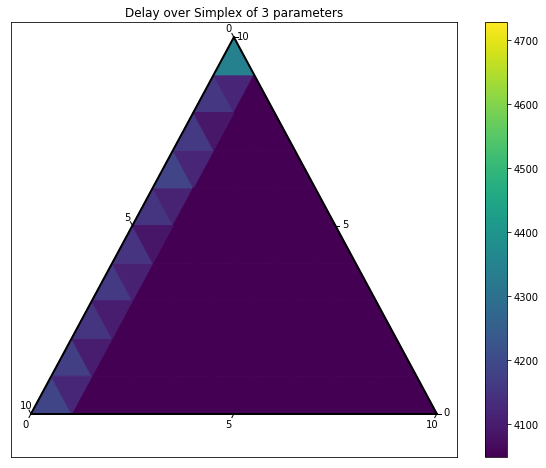

In [41]:
scale = 10

figure, tax = ternary.figure(scale=10)
figure.set_size_inches(10, 8)
tax.heatmap(delay_dict, style="triangular")
tax.boundary(linewidth=2.0)
tax.set_title("Delay over Simplex of 3 parameters")
tax.ticks(axis='lbr', linewidth=1, multiple=5)
tax.clear_matplotlib_ticks()
tax.show()

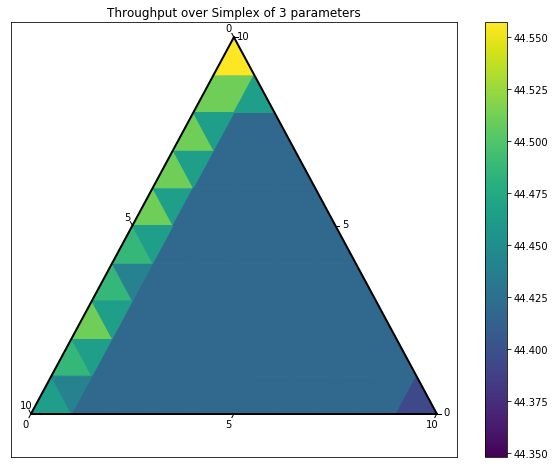

In [43]:
scale = 10

figure, tax = ternary.figure(scale=10)
figure.set_size_inches(10, 8)
tax.heatmap(thru_dict, style="triangular")
tax.boundary(linewidth=2.0)
tax.set_title("Throughput over Simplex of 3 parameters")
tax.ticks(axis='lbr', linewidth=1, multiple=5)
tax.clear_matplotlib_ticks()
tax.show()

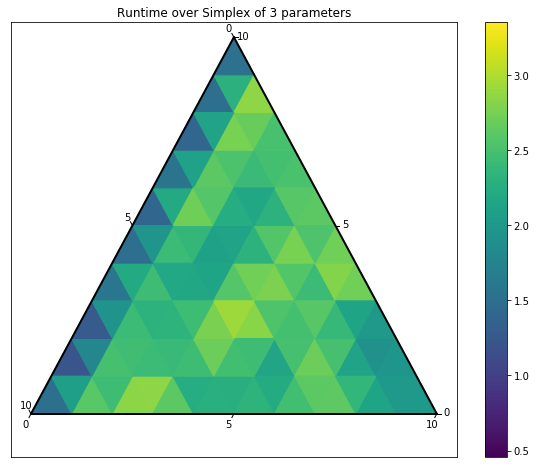

In [44]:
scale = 10

figure, tax = ternary.figure(scale=10)
figure.set_size_inches(10, 8)
tax.heatmap(runtime_dict, style="triangular")
tax.boundary(linewidth=2.0)
tax.set_title("Runtime over Simplex of 3 parameters")
tax.ticks(axis='lbr', linewidth=1, multiple=5)
tax.clear_matplotlib_ticks()
tax.show()

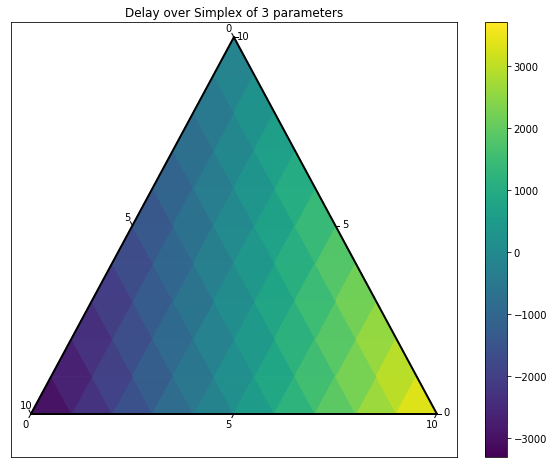

In [45]:
scale = 10

figure, tax = ternary.figure(scale=10)
figure.set_size_inches(10, 8)
tax.heatmap(obj_dict, style="triangular")
tax.boundary(linewidth=2.0)
tax.set_title("Delay over Simplex of 3 parameters")
tax.ticks(axis='lbr', linewidth=1, multiple=5)
tax.clear_matplotlib_ticks()
tax.show()

In [4]:
df = pd.read_pickle(DF_PATH + 'asymm_demand/results_simplex_d(\'750\', \'450\').pkl')

In [5]:
df

,demand,runtime,delay,throughput,objective_value,alpha,beta,gamma
0,"(750, 450)",0.583995,1.239797e+06,43.556962,-3527.426160,0.0,0.0,1.0
1,"(750, 450)",0.483014,1.239858e+06,44.417722,-3191.037052,0.0,0.1,0.9
2,"(750, 450)",0.535830,1.239837e+06,44.556962,-2855.274262,0.0,0.2,0.8
3,"(750, 450)",0.907932,1.239825e+06,44.556962,-2519.198312,0.0,0.3,0.7
4,"(750, 450)",0.599485,1.239856e+06,44.556962,-2183.122363,0.0,0.4,0.6
5,"(750, 450)",0.976176,1.239807e+06,44.556962,-1847.046414,0.0,0.5,0.5
6,"(750, 450)",0.561286,1.239760e+06,44.556962,-1510.970464,0.0,0.6,0.4
7,"(750, 450)",0.762853,1.239855e+06,44.556962,-1174.894515,0.0,0.7,0.3
8,"(750, 450)",0.420893,1.239751e+06,44.556962,-838.818565,0.0,0.8,0.2
9,"(750, 450)",0.731933,1.239830e+06,44.556962,-502.742616,0.0,0.9,0.1
